In [1]:
import sys
sys.path.append('./Documents/github/PAD/src/')
import Analyzer
import Grapher
import Munger
import Plasma_Plotter
import Scraper

In [2]:
dist = ['c:/Users/cschiff/Downloads/CDFs/mms2_fpi_brst_l2_des-dist_20151016130524_v3.3.0.cdf']
fgm  = ['c:/Users/cschiff/Downloads/CDFs/mms2_fgm_brst_l2_20151016130524_v4.18.0.cdf']
moms = ['c:/Users/cschiff/Downloads/CDFs/mms2_fpi_brst_l2_des-debug_20151016130524_v3.3.0.cdf']

In [3]:
help(Munger.make_munge_via_translation)

Help on function make_munge_via_translation in module Munger:

make_munge_via_translation(obs, type, delta, file_list, translation)
    Core function that uses an instrument-tailored hash to make a generic
    munge of all the data fed it in file_list



In [4]:
dist_munge = Munger.make_munge_via_translation('mms2','edist',Munger.des_delta,dist,Munger.edist_translation)

segment 1 - start: 2015-10-16 13:05:24.013945 stop 2015-10-16 13:07:43.965933
fresh segment - first stride
Munged 1 series for edist on mms2!


In [5]:
fgm_munge = Munger.make_munge_via_translation('mms2','fgm',Munger.fgm_delta,fgm,Munger.fgm_translation)

segment 1 - start: 2015-10-16 13:05:24.580997 stop 2015-10-16 13:07:43.574761
fresh segment - first stride
Munged 1 series for fgm on mms2!


In [6]:
moms_munge = Munger.make_munge_via_translation('mms2','emoms',Munger.des_delta,moms,Munger.emoms_translation)

segment 1 - start: 2015-10-16 13:05:24.013945 stop 2015-10-16 13:07:43.965933
fresh segment - first stride
Munged 1 series for emoms on mms2!


In [7]:
efgm_munge = Munger.adapt_munge_to_munge(fgm_munge,moms_munge)

fgm flavored


In [9]:
Analyzer.make_record_varying(dist_munge,'thetas')

In [10]:
Analyzer.calculate_incoming_particle_directions(dist_munge)

In [465]:
def calculate_B_local_transformation(sfgm_munge,moms_munge):
    #determine the number of strides
    num_strides = len(moms_munge)
    
   
    for N in range(num_strides):
        #determine the number of tknots in the current time series
        num_tknots = len(sfgm_munge[N]['epochs'])
        Bgse       = sfgm_munge[N]['Bgse'][:,0:3]
        U          = moms_munge[N]['bulk_vs']
        para       = Bgse/np.linalg.norm(Bgse,axis=1).reshape((num_tknots,1))
        perp2      = np.cross(Bgse,U)
        perp2      = perp2/np.linalg.norm(perp2,axis=1).reshape((num_tknots,1))
        perp1      = np.cross(perp2,para)
        T          = np.hstack((para,perp1,perp2)).reshape(num_tknots,3,3)      
        sfgm_munge[N]['T_localB'].reshape = T

In [466]:
def calculate_incoming_particle_velocities_at_time(dist_munge,stride,time_label,species):
    v_dirs = dist_munge[stride]['v_dirs'][time_label]
    ergs   = dist_munge[stride]['ergs'][time_label]
 
    #set physical constants, including the mass of the species
    c    = 29979245800.0 #cm/s
    km_s = 1.0e-5 #cm/s in terms of km/s 
    if species == 'electrons':
        ms = 0.5109989461e6/c**2 #ev/c^2
    if species == 'ions':
        ms = 938.2720813e6/c**2 #ev/c^2
        
    #set spectrometer parameters
    num_az    = 32
    num_polar = 16
    num_erg   = 32
    num_comps = 3

    speed = np.sqrt(2.0*ergs/ms)*km_s
        
    vels = np.zeros((num_az,num_polar,num_erg,num_comps))
    
    for j in range(num_az):
        for k in range(num_polar):
            vels[j,k,:,0] = speed*v_dirs[j,k,0]
            vels[j,k,:,1] = speed*v_dirs[j,k,1]
            vels[j,k,:,2] = speed*v_dirs[j,k,2]
            
    return vels

In [467]:
def calculate_incoming_particle_velocities(sdist_munge,species,frame):
    #determine the number of strides
    num_stride = len(dist_munge)

    #set spectrometer parameters
    num_az       = 32
    num_polar    = 16
    num_erg      = 32
    num_pixels   = num_az*num_polar
    num_channels = num_az*num_polar*num_erg

    #set physical constants, including the mass of the species
    c    = 299792.458000 #km/s
    if species == 'electrons':
        ms = 0.5109989461e6/c**2 #ev/c^2
    if species == 'ions':
        ms = 938.2720813e6/c**2 #ev/c^2

    num_comps = 3 
    
    for N in range(num_stride):
        #determine the number of tknots
        num_tknots = len(sdist_munge[N]['epochs'])
        
        #tile and reshape the incoming velocity directions
        v_dirs     = np.tile(dist_munge[N]['v_dirs'],num_erg)
        v_dirs     = v_dirs.reshape(num_tknots,num_channels,num_comps)
        
        #tile and reshape the energies
        ergs       = np.tile(dist_munge[N]['ergs'],num_pixels)
        ergs       = ergs.reshape(num_tknots,num_channels)
        
        #compute the speeds and velocities
        speeds      = np.sqrt(2.0*ergs/ms)
        vels        = np.zeros((num_tknots,num_channels,num_comps))
        vels[:,:,0] = speeds*v_dirs[:,:,0]
        vels[:,:,1] = speeds*v_dirs[:,:,1]
        vels[:,:,2] = speeds*v_dirs[:,:,2]        
        
        #add to the munge
        sdist_munge[N]['vels_frame'] = frame
        sdist_munge[N]['vels']       = vels

In [468]:
def calculate_index(val,min_val,max_val,num_points):
    #determine the delta
    delta  = (max_val - min_val)/(num_points - 1)
    offset = (num_points - 1)/2
    
    index =  int(np.around(val/delta)) + offset
    flag  = 0
    
    if index < 0:
        index = 0
        flag  = 1 
    if index > num_points - 1:
        index = num_points - 1
        flag = 1
        
    return index, flag

In [469]:
calculate_B_local_transformation(efgm_munge,moms_munge)

In [492]:
chosen_stride = 0
time_label    = 3272 #3272
print dist_munge[chosen_stride]['epochs'][time_label]

2015-10-16 13:07:02.175346


In [493]:
vels = calculate_incoming_particle_velocities_at_time(dist_munge,chosen_stride,time_label,'electrons')

In [494]:
#set spectrometer parameters
num_az    = 32
num_polar = 16
num_ergs  = 32
num_comps = 3
num_pixels = num_az*num_polar
num_channels = num_pixels*num_ergs

vels_B = np.zeros(vels.shape)
for i in range(num_az):
    for j in range(num_polar):
        for k in range(num_ergs):
            vels_B[i,j,k,:] = efgm_munge[chosen_stride]['T_localB'][time_label].dot(vels[i,j,k,:])

In [495]:
min_vel = -10000
max_vel = 10000
Dx      = 1000
num_points = (max_vel - min_vel)/Dx + 1

In [496]:
dist_grid = np.zeros((num_points,num_points))
N_grid    = np.zeros((num_points,num_points))
para_bin = np.linspace(-1.0e4,1.0e4,num_points)
perp1_bin = np.linspace(-1.0e4,1.0e4,num_points)
for i in range(num_az):
    for j in range(num_polar):
        for k in range(num_erg):
            #determine the bin location
            M,flagM = calculate_index(vels_B[i,j,k,0],min_vel,max_vel,num_points)
            N,flagN = calculate_index(vels_B[i,j,k,1],min_vel,max_vel,num_points)
            if flagM == 0 and flagN == 0:
                dist_grid[M,N] += dist_munge[chosen_stride]['dist'][time_label,i,j,k]
                N_grid[M,N]    += 1

2015-10-16 13:07:02.175346


C:\Users\cschiff\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\cschiff\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\cschiff\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.
C:\Users\cschiff\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


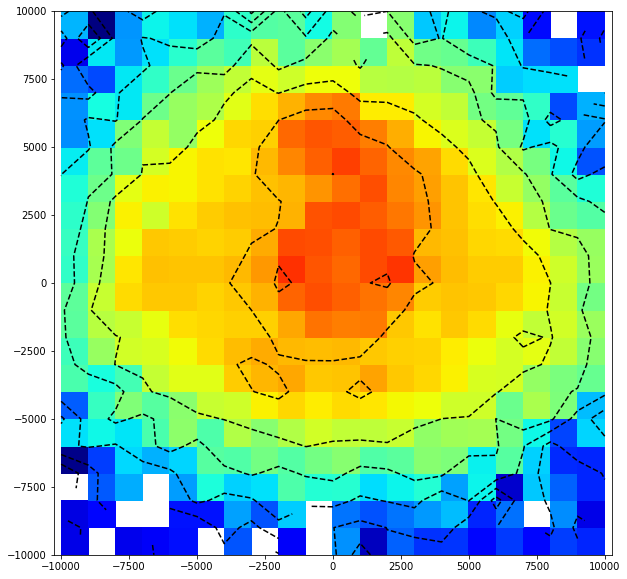

In [497]:
fig_v = plt.figure(figsize=(10,10))
ax_v  = fig_v.add_subplot(1,1,1) 
ax_v.pcolormesh(para_bin,perp1_bin,np.log10(dist_grid/N_grid).T,cmap=cmap.jet,vmin=-30,vmax=-25)
ax_v.contour(para_bin,perp1_bin,np.log10(dist_grid/N_grid).T,colors='k')
ax_v.axis('equal')
ax_v.set_xlim([-10000,10000])
ax_v.set_ylim([-10000,10000])
print dist_munge[chosen_stride]['epochs'][time_label]

In [498]:
QQ = np.tile(dist_munge[0]['ergs'],32*16)
QQ = QQ.reshape(4666,32,16,32)

In [499]:
Ergs = dist_munge[0]['ergs']

In [500]:
for i in range(32):
    for j in range(16):
        print "%s\t%s\t%s" %(i,j, np.max(np.abs(QQ[:,i,j,:] - Ergs)))

0	0	0.0
0	1	0.0
0	2	0.0
0	3	0.0
0	4	0.0
0	5	0.0
0	6	0.0
0	7	0.0
0	8	0.0
0	9	0.0
0	10	0.0
0	11	0.0
0	12	0.0
0	13	0.0
0	14	0.0
0	15	0.0
1	0	0.0
1	1	0.0
1	2	0.0
1	3	0.0
1	4	0.0
1	5	0.0
1	6	0.0
1	7	0.0
1	8	0.0
1	9	0.0
1	10	0.0
1	11	0.0
1	12	0.0
1	13	0.0
1	14	0.0
1	15	0.0
2	0	0.0
2	1	0.0
2	2	0.0
2	3	0.0
2	4	0.0
2	5	0.0
2	6	0.0
2	7	0.0
2	8	0.0
2	9	0.0
2	10	0.0
2	11	0.0
2	12	0.0
2	13	0.0
2	14	0.0
2	15	0.0
3	0	0.0
3	1	0.0
3	2	0.0
3	3	0.0
3	4	0.0
3	5	0.0
3	6	0.0
3	7	0.0
3	8	0.0
3	9	0.0
3	10	0.0
3	11	0.0
3	12	0.0
3	13	0.0
3	14	0.0
3	15	0.0
4	0	0.0
4	1	0.0
4	2	0.0
4	3	0.0
4	4	0.0
4	5	0.0
4	6	0.0
4	7	0.0
4	8	0.0
4	9	0.0
4	10	0.0
4	11	0.0
4	12	0.0
4	13	0.0
4	14	0.0
4	15	0.0
5	0	0.0
5	1	0.0
5	2	0.0
5	3	0.0
5	4	0.0
5	5	0.0
5	6	0.0
5	7	0.0
5	8	0.0
5	9	0.0
5	10	0.0
5	11	0.0
5	12	0.0
5	13	0.0
5	14	0.0
5	15	0.0
6	0	0.0
6	1	0.0
6	2	0.0
6	3	0.0
6	4	0.0
6	5	0.0
6	6	0.0
6	7	0.0
6	8	0.0
6	9	0.0
6	10	0.0
6	11	0.0
6	12	0.0
6	13	0.0
6	14	0.0
6	15	0.0
7	0	0.0
7	1	0.0
7	2	0.0
7	3	0.0
7	4	0.0
7	5	0.0
7	6	0.0
7	7	0.

In [501]:
calculate_incoming_particle_velocities(dist_munge,'electrons','gse')

In [502]:
QQ = dist_munge[0]['vels'].reshape(4666,32,16,32,3)

In [503]:
np.max(np.abs(QQ[time_label] - vels))

0.0072368045875919051

In [504]:
np.max(np.abs(QQ[time_label]))

98033.703704308835

In [505]:
np.max(np.abs(vels))

98033.703125

In [506]:
dist_munge[0]['vels'].shape

(4666L, 16384L, 3L)

In [507]:
QQQ = np.array([efgm_munge[0]['T_localB'][3272].dot(dist_munge[0]['vels'][3272,i,:]) for i in range(num_channels)])

In [508]:
min_vel = -10000
max_vel = 10000
Dx      = 1000
num_points = (max_vel - min_vel)/Dx + 1

dist_grid = np.zeros((num_points,num_points))
N_grid    = np.zeros((num_points,num_points))
para_bin = np.linspace(-1.0e4,1.0e4,num_points)
perp1_bin = np.linspace(-1.0e4,1.0e4,num_points)
for i in range(num_channels):
    #determine the bin location
    M,flagM = calculate_index(QQQ[i,0],min_vel,max_vel,num_points)
    N,flagN = calculate_index(QQQ[i,1],min_vel,max_vel,num_points)
    if flagM == 0 and flagN == 0:
        dist_grid[M,N] += dist_munge[chosen_stride]['dist'][time_label].reshape(num_channels)[i]
        N_grid[M,N]    += 1

2015-10-16 13:07:02.175346


C:\Users\cschiff\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\cschiff\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\cschiff\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.
C:\Users\cschiff\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


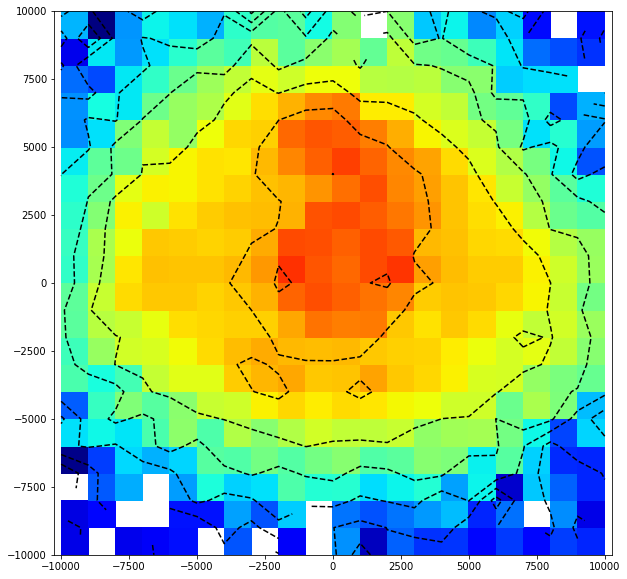

In [509]:
fig_v = plt.figure(figsize=(10,10))
ax_v  = fig_v.add_subplot(1,1,1) 
ax_v.pcolormesh(para_bin,perp1_bin,np.log10(dist_grid/N_grid).T,cmap=cmap.jet,vmin=-30,vmax=-25)
ax_v.contour(para_bin,perp1_bin,np.log10(dist_grid/N_grid).T,colors='k')
ax_v.axis('equal')
ax_v.set_xlim([-10000,10000])
ax_v.set_ylim([-10000,10000])
print dist_munge[chosen_stride]['epochs'][time_label]

In [485]:
QQQ.shape

(16384L, 3L)

In [520]:
delta = (max_vel - min_vel)/(num_points - 1)
offset = (num_points - 1)/2
print delta, offset
np.around(QQQ[:,0]/delta).astype(int) + offset

1000 10


array([  8,   8,   7, ...,  85,  94, 106])

In [523]:
def calculate_index(vals,min_val,max_val,num_points):
    #determine the delta
    delta  = (max_val - min_val)/(num_points - 1)
    offset = (num_points - 1)/2
    
    index = np.around(vals/delta).astype(int) + offset
    flag  = np.ones(len(vals))
    
    subzero_indices          = np.where(index < 0)
    over_9000_indices        = np.where(index > num_points - 1)
    index[subzero_indices]   = 0
    flag[subzero_indices]    = 0.0
    index[over_9000_indices] = num_points - 1
    flag[over_9000_indices]  = 0.0
        
    return index, flag

In [537]:
min_vel = -10000
max_vel = 10000
Dx      = 1000
num_points = (max_vel - min_vel)/Dx + 1

dist_grid = np.zeros((num_points,num_points))
N_grid    = np.zeros((num_points,num_points))
para_bin = np.linspace(-1.0e4,1.0e4,num_points)
perp1_bin = np.linspace(-1.0e4,1.0e4,num_points)
Qpara,  fpara  = calculate_index(QQQ[:,0],min_vel,max_vel,num_points)
Qperp1, fperp1 = calculate_index(QQQ[:,1],min_vel,max_vel,num_points)
for i in range(num_channels):
    #determine the bin location
    dist_grid[Qpara[i],Qperp1[i]] += fpara[i]*fperp1[i]*dist_munge[chosen_stride]['dist'][time_label].reshape(num_channels)[i]
    N_grid[Qpara[i],Qperp1[i]]    += 1

2015-10-16 13:07:02.175346


C:\Users\cschiff\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\cschiff\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\cschiff\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.
C:\Users\cschiff\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


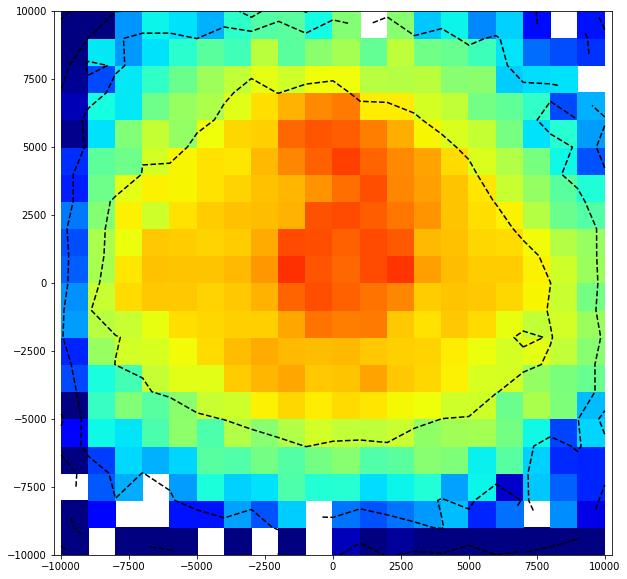

In [538]:
fig_v = plt.figure(figsize=(10,10))
ax_v  = fig_v.add_subplot(1,1,1) 
ax_v.pcolormesh(para_bin,perp1_bin,np.log10(dist_grid/N_grid).T,cmap=cmap.jet,vmin=-30,vmax=-25)
ax_v.contour(para_bin,perp1_bin,np.log10(dist_grid/N_grid).T,5,colors='k')
ax_v.axis('equal')
ax_v.set_xlim([-10000,10000])
ax_v.set_ylim([-10000,10000])
print dist_munge[chosen_stride]['epochs'][time_label]